# Stochastic Gradient Descent
:label:`sec_sgd`

In earlier chapters we kept using stochastic gradient descent in our training procedure, however, without explaining why it works.
To shed some light on it,
we just described the basic principles of gradient descent
in :numref:`sec_gd`.
In this section, we go on to discuss
*stochastic gradient descent* in greater detail.


In [ ]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def train_2d(trainer, steps=20, f_grad=None):
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results
def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    #set_figsize()
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-55, 1, 1),
                          np.arange(-30, 1, 1))
    x1, x2 = x1*0.1, x2*0.1
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

## Stochastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset.
Given a training dataset of $n$ examples,
we assume that $f_i(\mathbf{x})$ is the loss function
with respect to the training example of index $i$,
where $\mathbf{x}$ is the parameter vector.
Then we arrive at the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computational cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the  training dataset is larger, the cost of gradient descent for each iteration will be higher.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

where $\eta$ is the learning rate. We can see that the computational cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. Moreover, we want to emphasize that the stochastic gradient $\nabla f_i(\mathbf{x})$ is an unbiased estimate of the full gradient $\nabla f(\mathbf{x})$ because

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it with gradient descent by adding random noise with a mean of 0 and a variance of 1 to the gradient to simulate a stochastic gradient descent.


In [ ]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

In [ ]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += np.random.normal(0.0, 1, (1,))
    g2 += np.random.normal(0.0, 1, (1,))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

epoch 50, x1: -0.135981, x2: 0.136975


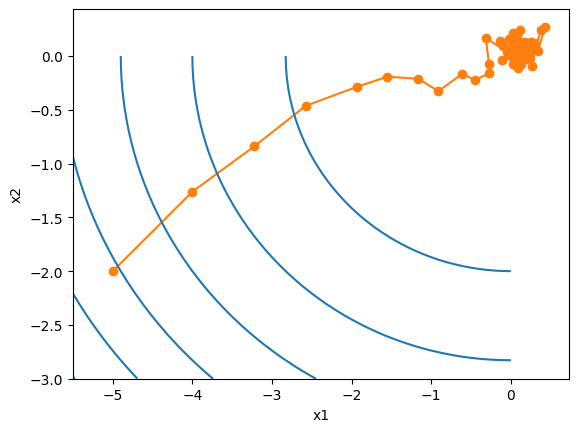

In [ ]:
def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_grad))

As we can see, the trajectory of the variables in the stochastic gradient descent is much more noisy than the one we observed in gradient descent in :numref:`sec_gd`. This is due to the stochastic nature of the gradient. That is, even when we arrive near the minimum, we are still subject to the uncertainty injected by the instantaneous gradient via $\eta \nabla f_i(\mathbf{x})$. Even after 50 steps the quality is still not so good. Even worse, it will not improve after additional steps (we encourage you to experiment with a larger number of steps to confirm this). This leaves us with the only alternative: change the learning rate $\eta$. However, if we pick this too small, we will not make any meaningful progress initially. On the other hand, if we pick it too large, we will not get a good solution, as seen above. The only way to resolve these conflicting goals is to reduce the learning rate *dynamically* as optimization progresses.

This is also the reason for adding a learning rate function `lr` into the `sgd` step function. In the example above any functionality for learning rate scheduling lies dormant as we set the associated `lr` function to be constant.

## Dynamic Learning Rate

Replacing $\eta$ with a time-dependent learning rate $\eta(t)$ adds to the complexity of controlling convergence of an optimization algorithm. In particular, we need to figure out how rapidly $\eta$ should decay. If it is too quick, we will stop optimizing prematurely. If we decrease it too slowly, we waste too much time on optimization. The following are a few basic strategies that are used in adjusting $\eta$ over time (we will discuss more advanced strategies later):

$$
\begin{aligned}
    \eta(t) & = \eta_i \textrm{ if } t_i \leq t \leq t_{i+1}  && \textrm{piecewise constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \textrm{exponential decay} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \textrm{polynomial decay}
\end{aligned}
$$

In the first *piecewise constant* scenario we decrease the learning rate, e.g., whenever progress in optimization stalls. This is a common strategy for training deep networks. Alternatively we could decrease it much more aggressively by an *exponential decay*. Unfortunately this often leads to premature stopping before the algorithm has converged. A popular choice is *polynomial decay* with $\alpha = 0.5$. In the case of convex optimization there are a number of proofs that show that this rate is well behaved.

Let's see what the exponential decay looks like in practice.


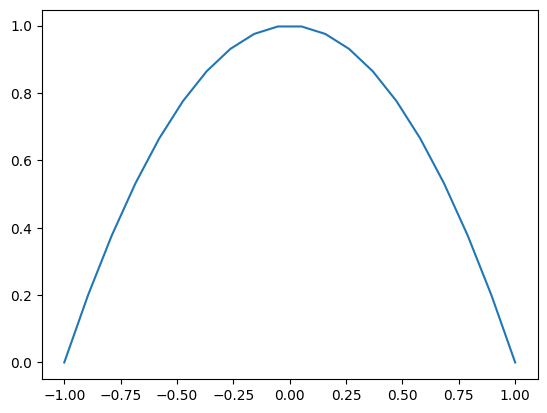

In [ ]:
x=np.linspace(-1,1,20)
plt.plot(x, -x**2+1)

epoch 1000, x1: -0.709379, x2: -0.104014


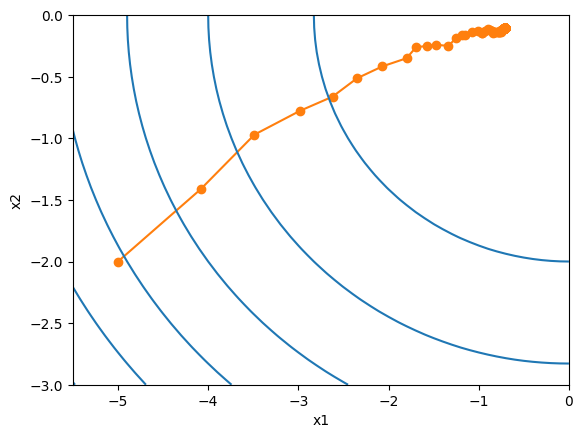

In [ ]:
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
show_trace_2d(f, train_2d(sgd, steps=1000,f_grad=f_grad))

As expected, the variance in the parameters is significantly reduced. However, this comes at the expense of failing to converge to the optimal solution $\mathbf{x} = (0, 0)$. Even after 1000 iteration steps are we are still very far away from the optimal solution. Indeed, the algorithm fails to converge at all. On the other hand, if we use a polynomial decay where the learning rate decays with the inverse square root of the number of steps, convergence gets better after only 50 steps.


epoch 50, x1: -0.123270, x2: 0.032951


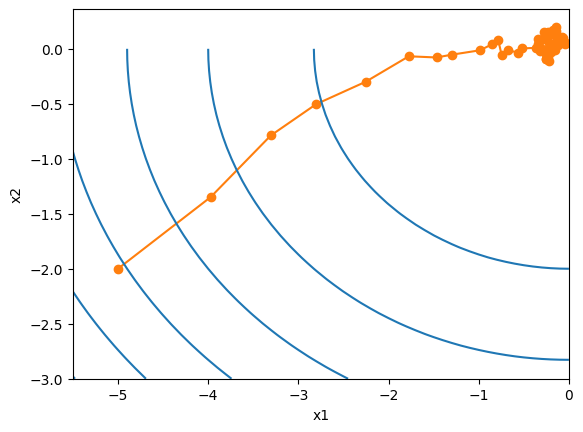

In [ ]:
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_grad))

Powered by dl2.ai